
<h1><center>Predicting Profitable Customer Groups</center></h1>
<h3><center>Omid Charrakh</center></h3>

<hr>

<h1>Introduction</h1>


In this dataset, we have 71 columns, including 70 features and one target variable. The target variable can be predicted from the 70 features via a classification method. Among the 70 features, 67 features are primary, and three features (i.e., g1_21, g2_21, and c_28) are secondary; each secondary feature can be approximated from its corresponding primary features by a regression method. Hence, to tackle the problem, we need to combine three regressions with one classification machine learning algorithm.

In this notebook, after performing some preprocessing and visualization tasks, I will train and test four different classifiers (i.e., SVM, RF, XGB, and MLP) for the primary features. The hyperparameters of each classifier will be tuned by exploiting cross-validation techniques, their confusion matrices will be sketched, and their possibilities of becoming overfitting will be carefully analyzed. As will be argued, my tuned MLP model can be accepted as my best classifier. After choosing the tuned MLP classifier, I will then implement three multi-linear regressions corresponding to the three secondary features. The three predictions obtained from the said regressions will be plugged into our tuned MLP classifier so we can get the most optimal model for the dataset, called REG-MLP. The last section of the notebook will provide some suggestions for improving the future performance of our model.

<hr>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol> 
        <li><a href="#Preprocessing">Preprocessing and Primary Visualizations</a></li>        
        <li><a href="#Classifiers">Building Optimized Models</a></li>
            <ol>
                <li><a href="#SVM">Support Vector Machine (SVM)</a></li>
                <li><a href="#RF">Random Forest (RF)</a></li>
                <li><a href="#RF">X Gradient Boost (XGB)</a></li>
                <li><a href="#MLP">Multi Layer Perceptron (MLP)</a></li>
                <li><a href="#REG">Multi Linear Regression (REG)</a></li>
            </ol>
        <li><a href="#plus">Regressions Plus the Classfication (REG-MLP)</a></li> 
        <li><a href="#API">API</a></li>
        <li><a href="#Results">Final Results and Discussion</a></li>
    </ol>
</div>
<br>


<hr>
<h1 id="Preprocessing">Preprocessing and Primary Visualizations</h1>

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, learning_curve,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, datasets
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import randint as sp_randint
from itertools import cycle
import collections
from collections import OrderedDict
from statistics import mean 
from operator import itemgetter
import operator
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime

from pprint import pprint

In [2]:
df = pd.read_csv('../data/customerGroups.csv')
df.head()
df.shape

(6620, 71)

In [3]:
df['target'].value_counts(normalize=True)

1    0.464653
2    0.283535
0    0.251813
Name: target, dtype: float64

In [9]:
x_1,x_2,x_0=list(df['target'].value_counts())

p_1=100*x_1/(x_1+x_2+x_0)

p_2=100*x_2/(x_1+x_2+x_0)

p_3=100*x_0/(x_1+x_2+x_0)

print('Hence, %.2f%% and %.2f%% of campaigns led to group 1 and group 2 being the most profitable, respectively.\nNevertheless, %.2f%% of the campaigns were completely unsuccessful.' % (p_1, p_2, p_3))

Hence, 46.47% and 28.35% of campaigns led to group 1 and group 2 being the most profitable, respectively.
Nevertheless, 25.18% of the campaigns were completely unsuccessful.


# __Remark:__

The above calculation reveals that our dataset is __balanced__ and we no longer need to be worried about this issue. 

In the next cell, we will extract the 67 primary features of the dataset (i.e., all features except g1_21, g2_21, and c_28) and will call them as __feature_base__. For the moment, we will only focus on these features. We will also __normalize__ these features (i.e., zero mean and unit variance) and will split them into __train 80%, test 20%__.

In [4]:
# Separating out all the features

features_all = ['g1_1', 'g1_2', 'g1_3', 'g1_4', 'g1_5', 'g1_6', 'g1_7', 'g1_8', 'g1_9',
       'g1_10', 'g1_11', 'g1_12', 'g1_13', 'g1_14', 'g1_15', 'g1_16', 'g1_17',
       'g1_18', 'g1_19', 'g1_20', 'g1_21', 'g2_1', 'g2_2', 'g2_3', 'g2_4',
       'g2_5', 'g2_6', 'g2_7', 'g2_8', 'g2_9', 'g2_10', 'g2_11', 'g2_12',
       'g2_13', 'g2_14', 'g2_15', 'g2_16', 'g2_17', 'g2_18', 'g2_19', 'g2_20',
       'g2_21', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9',
       'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17', 'c_18',
       'c_19', 'c_20', 'c_21', 'c_22', 'c_23', 'c_24', 'c_25', 'c_26', 'c_27',
       'c_28']

#Considering features that merely include the base columns (i.e., in this step, we don't care about g1_21, g2_21 and c_28)

features_base = ['g1_1', 'g1_2', 'g1_3', 'g1_4', 'g1_5', 'g1_6', 'g1_7', 'g1_8', 'g1_9',
       'g1_10', 'g1_11', 'g1_12', 'g1_13', 'g1_14', 'g1_15', 'g1_16', 'g1_17',
       'g1_18', 'g1_19', 'g1_20', 'g2_1', 'g2_2', 'g2_3', 'g2_4',
       'g2_5', 'g2_6', 'g2_7', 'g2_8', 'g2_9', 'g2_10', 'g2_11', 'g2_12',
       'g2_13', 'g2_14', 'g2_15', 'g2_16', 'g2_17', 'g2_18', 'g2_19', 'g2_20',
       'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9',
       'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17', 'c_18',
       'c_19', 'c_20', 'c_21', 'c_22', 'c_23', 'c_24', 'c_25', 'c_26', 'c_27']


#Later, we will use the denormalized features for our Random Forest Classifier 
X_denorm=df.loc[:, features_all].values

# Standardization of the features
X = StandardScaler().fit_transform(X_denorm)

# Separating out the target
y = np.ravel(df.loc[:,['target']].values)

#train-test split 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

x=np.hstack((X[:,0:20], X[:,21:41], X[:,42:69]))

x_train=np.hstack((X_train[:,0:20], X_train[:,21:41], X_train[:,42:69]))

x_test=np.hstack((X_test[:,0:20], X_test[:,21:41], X_test[:,42:69]))


# __PCA Visualization:__

 
Two essential questions to be answered are as follows: 

- 1) Can we expect the variables to be __linearly separable__?

- 2) Does adding the (three) secondary columns help?


__Principal component analysis (PCA)__ can help us to answer the above questions. As will be shown in the next cell, the answer to both questions is negative, implying that even if we consider all the (primary and secondary) features, we need to exploit a non-linear model for our classification task.

In [20]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

finalDf

,principal component 1,principal component 2,target
0,-2.459037,-3.329807,2
1,-0.551571,3.823804,1
2,-8.107830,2.019203,2
3,0.428156,-4.323988,0
4,-1.477034,5.148091,2
...,...,...,...
6615,1.233331,-2.307510,1
6616,3.313511,-1.275053,0
6617,-1.313978,-1.704331,1
6618,0.417239,-4.372111,1


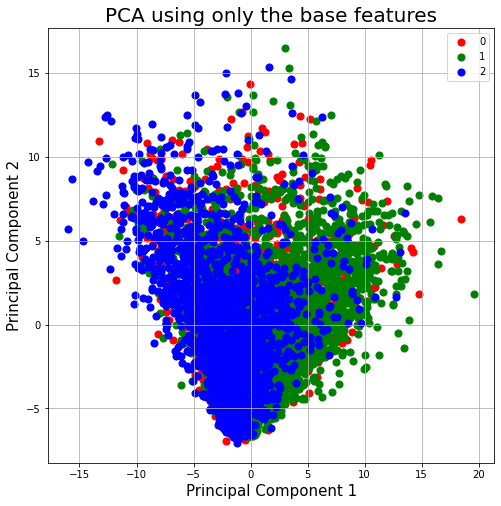

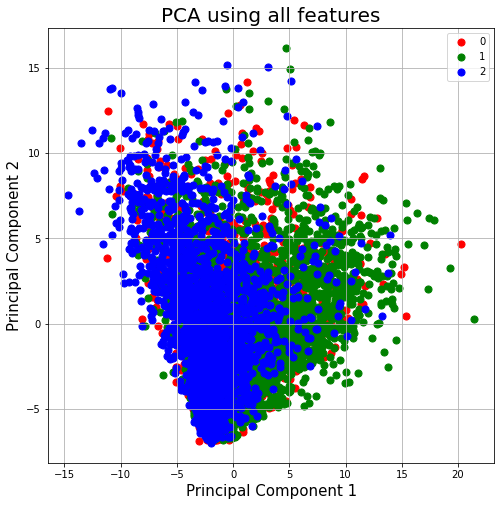

In [13]:
#Evaluating the linear independence of our primary variables via PCA analysis:

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA using only the base features', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


#Evaluating the role of the (three) secondary features in our PCA analysis: 

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)


fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA using all features', fontsize = 20)

targets = [0, 1, 2]
colors = ['r', 'g', 'b']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()




# __Remark:__

Adding the three secondary features did not improve the linear independence of our data. To understand the reason why this happens, it is useful to check the __correlation coefficients__ of each feature with the target variable. The next cell will compute the said coefficients. 


Importantly, although the situation for c_28 is a bit better, the other two features (i.e., g1_21 and g2_21) are not highly correlated with the target variable. This fact explains the reason why adding the secondary features to our PCA analysis did not significantly improve our results.


In [ ]:
corr_matrix = df.corr()

Correlation_coeffients= dict(abs(corr_matrix['target'][0:70]).sort_values(ascending=False)).keys()

print (list(Correlation_coeffients))


# g1_1, c_2, c_12 , c_19, c_20, c_8, c_21, c_26, c_25, and g2_12 are the most correlated features with the target variable.

<hr>

<h1 id="Classifiers">Building Classifier</h1>

This section will firstly implement three __baseline classifiers__ (i.e., __SVM, RF, XGB__) using only primary features. For each of the mentioned classifiers, the following tasks will be performed.

- 1) Measure the __performance__ (confusion matrix, F-score, precision-recall)

- 2) Check the possibility of __overfitting__ 

- 3) Use cross validation to __tune the hyperparameters__


I will then continue by implementing a __fancier classifier__ (i.e., __2-3 layer feed-forward network MLP__) and will perform the above tasks for it.

In [25]:
yhat_base_svm.shape

(1324,)

<hr>
<h3 id="SVM">Support Vector Machine (SVM)</h3>



In [23]:
#Applying SVM to the base features

base_svm = svm.SVC()
base_svm.fit(x_train, y_train)
yhat_base_svm = base_svm.predict(x_test)

print("Training accuracy for SVM when it cosiders merely the base features: {0:.3f}".format(base_svm.score(x_train, y_train)))
print("Test accuracy for SVM when it cosiders merely the base features: {0:.3f}".format(base_svm.score(x_test, y_test)))

Training accuracy for SVM when it cosiders merely the base features: 0.620
Test accuracy for SVM when it cosiders merely the base features: 0.579


In [1]:
#Hyperparameter Optimization of the base SVM 

parameter_space_svm = [{'C': [1, 10, 100, 500, 1000], 'gamma': [.01, 0.001, 0.0001, 'scale'], 'kernel': ['rbf'], 'class_weight':['balanced', None]}]

    
svc = svm.SVC()

# Create a classifier object with the classifier and parameter candidates
gs_svm = GridSearchCV(estimator=svc,param_grid=parameter_space_svm, n_jobs=-1)

# Train the classifier on data's features and target data
gs_svm.fit(x_train, y_train)


print('Best score for training data:', gs_svm.best_score_)
print('Best parameters found:\n', gs_svm.best_params_)

NameError: name 'svm' is not defined

In [ ]:
#Hence the best hyperparameters for our SVM would be as follows: 
tuned_svm = svm.SVC(kernel='rbf', C=100, gamma=0.0001, class_weight=None)


#Let us train our tuned SVM and compute its corresponding accuracy scores
tuned_svm.fit(x_train, y_train)
yhat_tuned_svm = tuned_svm.predict(x_test)


print("Training accuracy for the tuned SVM: {0:.3f}".format(tuned_svm.score(x_train, y_train)))
print("Test accuracy for the tuned  SVM: {0:.3f}".format(tuned_svm.score(x_test, y_test)))

In [ ]:
# A function for ploting the confusion matrix of each model. 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(8, 8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix for the tuned SVM
tuned_svm_matrix = confusion_matrix(y_test, yhat_tuned_svm, labels=[1,2,0])
np.set_printoptions(precision=2)


print (classification_report(y_test, yhat_tuned_svm))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(tuned_svm_matrix, classes=['First (1)','Second (2)', 'None (0)'], normalize= True,  title='Normalized confusion matrix\n (Tuned SVM)')


<hr>

<h3 id="RF">Random Forest (RF)</h3>


It is a well-known fact that Random Forest algorithms are not sensitive to denormalized datasets. Even, sometimes it is recommended to train and test RG models with denormalized data. Hence, in this part, we will use denormalized variables.

In [ ]:
#Train-test split of the denormalized dataset 
X_train_denorm, X_test_denorm, y_train_denorm, y_test_denorm = train_test_split( X_denorm, y, test_size=0.2, random_state=42)
x_denorm=np.hstack((X_denorm[:,0:20], X_denorm[:,21:41], X_denorm[:,42:69]))
x_train_denorm=np.hstack((X_train_denorm[:,0:20], X_train_denorm[:,21:41], X_train_denorm[:,42:69]))
x_test_denorm=np.hstack((X_test_denorm[:,0:20], X_test_denorm[:,21:41], X_test_denorm[:,42:69]))


#Create a Gaussian Classifier for the base features
#To avoid overfitting, I changed the default parameters of the classifier
base_rf=RandomForestClassifier(n_estimators=150, max_features=14, min_samples_leaf=14, max_depth=150)
base_rf.fit(x_train_denorm,y_train_denorm)
yhat_base_rf=base_rf.predict(x_test_denorm)


print("Training Accuracy for the basic RF: {0:.3f}".format(base_rf.score(x_train_denorm, y_train_denorm)))
print("Test Accuracy for the basic RF: {0:.3f}".format(base_rf.score(x_test_denorm, y_test_denorm)))

In [ ]:
#Hyperparameter Optimization of the base RF


# Let us print the parameters used by our current forest
rf = RandomForestRegressor(random_state = 42)
print('Parameters currently in use:\n')
pprint(rf.get_params())


#Specify the random grid
n_estimators = [int(x) for x in np.linspace(1, 500, num = 50)]
max_features = [10, 14, 20]
max_depth = [int(x) for x in np.linspace(10, 500, num = 50)]
max_depth.append(None)
min_samples_leaf = [2, 4, 10, 14, 20]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, n_jobs = -1)
rf_random.fit(x_train_denorm,y_train_denorm)
              

print('Best parameters found:\n', rf_random.best_params_)

In [ ]:
#Hence our best tuned RF would be as follows: 
tuned_rf=RandomForestClassifier(n_estimators=225, min_samples_split=2, min_samples_leaf=20, max_features=14, max_depth=160, bootstrap=False)


#Let us train our tuned SVM and compute its corresponding accuracy scores
tuned_rf.fit(x_train_denorm,y_train_denorm)
yhat_tuned_rf=tuned_rf.predict(x_test_denorm)

print("Training accuracy for the tuned RF: {0:.3f}".format(tuned_rf.score(x_train_denorm, y_train_denorm)))
print("Test accuracy for the tuned RF: {0:.3f}".format(tuned_rf.score(x_test_denorm, y_test_denorm)))

In [ ]:
# Compute confusion matrix for the tuned RF
tuned_rf_matrix = confusion_matrix(y_test_denorm, yhat_tuned_rf, labels=[1,2,0])
np.set_printoptions(precision=2)

print (classification_report(y_test_denorm, yhat_tuned_rf))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(tuned_rf_matrix, classes=['First (1)','Second (2)', 'None (0)'],normalize= True,  title='Normalized confusion matrix\n (Tuned RF)')

In [ ]:
feature_imp = pd.Series(tuned_rf.feature_importances_,index=features_base).sort_values(ascending=False)


# Creating a bar plot

plt.figure(figsize=(10,20))
sns.barplot(feature_imp, feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()


#Hence, some of the most important features for the RF classifier:'c_2', 'g1_1', 'g2_1', 'c_4', 'c_20', 'c_9', 'c_25', 'c_26', 'c_1'


<hr>
<h3 id="MLP">XGradient Boost (XGB)</h3>

In [ ]:
#Tunning the hyperparameters of a XGB algorithm for the base features

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2, 5, 8],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [.2, 0.6],
        'max_depth': [3, 5, 10],
        'n_estimators' : [int(x) for x in np.linspace(1, 800, num = 50)]
        }


xgb = XGBClassifier(learning_rate=0.1,objective='reg:logistic', silent=True, nthread=1)
random_search = RandomizedSearchCV(xgb, param_distributions=params, scoring='accuracy', n_iter=15, n_jobs= -1, cv=3, verbose=3, random_state=42 )
random_search.fit(x_train, y_train)


print('\n Best hyperparameters:')
print(random_search.best_params_)

In [ ]:
#Hence our best tuned XGB would be as follows: 
tuned_xgb = XGBClassifier(n_estimators=620, learning_rate=0.038, min_child_weight=10, gamma=8, max_depth=5, colsample_bytree=.2, subsample=.8)


#Let us train our tuned XGB and compute its corresponding accuracy scores
tuned_xgb.fit(x_train, y_train)
yhat_tuned_xgb=tuned_rf.predict(x_test)


print("Training accuracy for the tuned XGB: {0:.3f}".format(tuned_xgb.score(x_train, y_train)))
print("Test accuracy for the tuned XGB: {0:.3f}".format(tuned_xgb.score(x_test, y_test)))

# Compute confusion matrix for the tuned XGB
tuned_xgb_matrix = confusion_matrix(y_test, yhat_tuned_xgb, labels=[1,2,0])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_tuned_xgb))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(tuned_xgb_matrix, classes=['First (1)','Second (2)', 'None (0)'],normalize= True,  title='Normalized confusion matrix\n (Tuned XGB)')

<hr>
<h3 id="MLP">Multi-layer Perceptron (MLP)</h3>

In [ ]:
#Basic MLP: a fancier classifier (2-3 layer feed-forward network MLP) for the base features

base_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 20), max_iter=300, activation = 'relu',random_state=42)


base_mlp.fit(x_train, y_train)
yhat_base_mlp = base_mlp.predict(x_test)

print("Training accuracy for the basic MLP: {0:.3f}".format(base_mlp.score(x_train, y_train)))
print(" Test accuracy for the basic MLP: {0:.3f}".format(base_mlp.score(x_test, y_test)))

In [ ]:
#Hyperparameter Optimization of the base MLP

parameter_space_mlp = {'solver': ['lbfgs'], 'max_iter': [100, 200, 300], 'alpha': [1e-5, 1e-3], 'hidden_layer_sizes': [(100,),(10, 20), (9,6,3)],'learning_rate': ['adaptive', 'constant']}

mlp= MLPClassifier()
gs_mlp = GridSearchCV(mlp, parameter_space_mlp, cv = 3, n_jobs=-1)
gs_mlp.fit(x_train, y_train)


print('Best score for training data:', gs_mlp.best_score_)
print('Best parameters found:\n', gs_mlp.best_params_)

In [ ]:
#Hence the best tuned MLP would be as follows: 

tuned_mlp=MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(9, 6, 3), max_iter=100, learning_rate='constant')

#Now, we train such a tuned MLP and then compute its corresponding accuracy scores
tuned_mlp.fit(x_train, y_train)
yhat_tuned_mlp = tuned_mlp.predict(x_test)

print("Training accuracy for the tuned MLP: {0:.3f}".format(base_mlp.score(x_train, y_train)))
print(" Test accuracy for the tuned MLP: {0:.3f}".format(base_mlp.score(x_test, y_test)))


# Compute confusion matrix
tuned_mlp_matrix = confusion_matrix(y_test, yhat_tuned_mlp, labels=[1,2,0])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_tuned_mlp))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(tuned_mlp_matrix, classes=['First (1)','Second (2)', 'None (0)'],normalize= True,  title='Normalized confusion matrix\n (Tuned MLP)')

<hr>

# False Predictions:

By implementing four classifiers (__SVM, RF, XGB, MLP__), we obtained several confusion matrices and accuracy scores. The remaining task is to define a __criterion for choosing the best classifier__. A naive approach is to select the model which has the highest F-score or Jaccard index. However, such a naive criterion may not be precise from a business point of view. In particular, one should note that __the importance of different False Predictions is not similar__. For instance, a False Negative (FN) prediction that assigns "0" label to true labels "1" or "2" imposes a higher financial loss than a FN prediction that assigns "1" or "2" label to a true label "0" (simply because the former leads to ignoring some profitable customer groups, but, the latter leads to at most an ineffective campaign). Hence, for choosing the best classifier for business purposes, one may be better to concentrate on the 3×1 and 2×2 elements of the confusion matrices: __these two should be maximized__.

<hr>

- __Best Classifier__: It seems to be reasonable to accept the __MLP as our best candidate classifier__. Accordingly, for the rest of the notebook, I will focus on MLP and will combine it with the three regression models. 



- __Remark__: For future investigations, one suggestion is to record the cost of each campaign and add it to the dataset. By doing so, we would be able to evaluate the importance of the other FN predictions (e.g., 1×2 and 1×3 elements) and come up with more optimal classifiers.

<hr>

<h3 id="REG">Multi Linear Regression (REG)</h3>

As explained earlier, the basic idea of this section is to implement __three regression models corresponding to the three secondary features (g1_21, g2_21, c_28)__. We will then combine the predictions obtained from these regressions with the MLP classifier. 


In [ ]:
# First Regression Problem: Using g1_1,..., g1_20 to predict g1_21

# Second Regression Problem: Using g2_1,..., g2_20 to predict g2_21

# Third Regression Problem: Using c_1,..., c_27 to predict c_28




#g1_train =(g1_1_train, g1_2_train,..., g1_20_train)
#g2_train =(g2_1_train, g2_2_train,..., g2_20_train)
#c_train =(c_1train, c_2train,..., c_27train)


g1_train=X_train[:,0:20]
g1_21train=X_train[:,20]
g2_train=X_train[:,21:41]
g2_21train=X_train[:,41]
c_train=X_train[:,42:69]
c_28train=X_train[:,69]


#g1_test =(g1_1_test, g1_2_test,..., g1_20_test)
#g2_test =(g2_1_test, g2_2_test,..., g2_20_test)
#c_test =(c_1test, c_2test,..., c_27test)

g1_test=X_test[:,0:20]
g1_21test=X_test[:,20]
g2_test=X_test[:,21:41]
g2_21test=X_test[:,41]
c_test=X_test[:,42:69]
c_28test=X_test[:,69]

target_train=y_train
target_test=y_test


reg1 = LinearRegression().fit(g1_train, g1_21train)
reg2 = LinearRegression().fit(g2_train, g2_21train)
reg3 = LinearRegression().fit(c_train, c_28train)


g1_21predict_train= reg1.predict(g1_train)
g2_21predict_train= reg2.predict(g2_train)
c_28predict_train= reg3.predict(c_train)

g1_21predict_test= reg1.predict(g1_test)
g2_21predict_test= reg2.predict(g2_test)
c_28predict_test= reg3.predict(c_test)


X_Train= np.hstack((np.hstack((g1_train, g2_train, c_train)), np.vstack((g1_21predict_train, g2_21predict_train, c_28predict_train)).T))
X_Test=np.hstack((np.hstack((g1_test, g2_test, c_test)), np.vstack((g1_21predict_test, g2_21predict_test, c_28predict_test)).T))

Y_Train=y_train
Y_Test=y_test


print("Residual sum of squares for the first regression: %.2f"
      % np.mean((g1_21predict_test - g1_21test) ** 2))
print('Variance score for the first regression: %.2f' % reg1.score(g1_test, g1_21test))


print("Residual sum of squares for the second regression: %.2f"
      % np.mean((g2_21predict_test - g2_21test) ** 2))
print('Variance score for the second regression: %.2f' % reg2.score(g2_test, g2_21test))


print("Residual sum of squares for the third regression: %.2f"
      % np.mean((c_28predict_test - c_28test) ** 2))
print('Variance score for the third regression: %.2f' % reg3.score(c_test, c_28test))




# Remark:
__Considering the fact that the above variance scores are high enough, we can assert that our three linear regressions are working well. In the next cell, we will combine the three regressions' predictions with the primary feature values. By doing so, we will have a new MLP classifier which accepts 70 variables as its inputs (the inputs of the new classifier are 67 "actual" primary features and 3 "predicted" secondary features). I will tune the hyperparameters of this new MLP and will compute its the confusion matrix.__

In [ ]:
#Hyperparameter Optimization of the new MLP classifier; i.e., the combination of MLP with the three REGs (called REG_MLP)

parameter_reg_mlp = {'solver': ['lbfgs'], 'max_iter': [100, 200, 300], 'alpha': [1e-5, 1e-3], 'hidden_layer_sizes': [(100,),(10, 20), (9,6,3)],'learning_rate': ['adaptive', 'constant']}

reg_mlp= MLPClassifier()
gs_reg_mlp = GridSearchCV(reg_mlp, parameter_reg_mlp, cv = 3, n_jobs=-1)
gs_reg_mlp.fit(X_Train, Y_Train)


print('Best score for training data:', gs_reg_mlp.best_score_)
print('Best parameters found:\n', gs_reg_mlp.best_params_)

In [ ]:
#Hence the REG-MLP can be fine_tuned as follows: 

reg_mlp=MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(9, 6, 3), max_iter=100, learning_rate='adaptive')

reg_mlp.fit(X_Train, Y_Train)
yhat_reg_mlp = reg_mlp.predict(X_Test)

print("Training accuracy for the REG-MLP: {0:.3f}".format(reg_mlp.score(X_Train, Y_Train)))
print("Test accuracy for the REG-MLP: {0:.3f}".format(reg_mlp.score(X_Test, Y_Test)))


# Compute confusion matrix
reg_mlp_matrix = confusion_matrix(Y_Test, yhat_reg_mlp, labels=[1,2,0])
np.set_printoptions(precision=2)

print (classification_report(Y_Test, yhat_reg_mlp))

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(reg_mlp_matrix, classes=['First (1)','Second (2)', 'None (0)'],normalize= True,  title='Normalized confusion matrix\n (Mixing Regressions with MLP)')

<hr>

<h1 id="API">API</h1>


The basic idea of the following API is as follows: 

- 1) To load a pre-trained classifier (in this example, REG-MLP),
- 2) To import the data from a data path, 
- 3) To export the corresponding predictions to an output path.

In [ ]:
import flask
import pickle
import numpy as np

from flask import request
from flask import jsonify

app = flask.Flask(__name__)
app.config["DEBUG"] = True

model_path = "http//127.0.0.1:5000/classifier"
model = pickle.load(model_path)

@app.route('/reg_mlp', methods=['POST'])
def classify():

    req_data = request.get_json()
    data = req_data['data']

    x = np.asarray(data)
    y = model.predict([x]) 
    y = [0]

    res = {"v":"0.0", "prediction": y[0]}

    return jsonify(res)

app.run()

<hr>
<h1 id="Results"> Final Results and Discusstion</h1>

<hr>

1. What percentage of campaigns led to group 1 being the most profitable? What about group 2? And neither of the groups?



__Approximately, 46.47% and 28.35% of campaigns led to group 1 and group 2 being the most profitable, respectively. Moreover, 25.18% of the campaigns were completely unsuccessful.__

<hr>


2. Based on all the information you have, can you build a model to optimize future campaigns? Given the characteristics of two different groups of customers, please predict which group to target.

__Yes! One can choose the last optimized model, i.e., the REG-MLP model. This model accepts the 67 primary features as its input; predicts the three secondary features; and then applies a MLP classification method to predict the corresponding target value for each campaign.__ 

<hr>


3. By how much do you think your model could improve campaign success rates? How would you test that?

__To test the prediction power of my REG-MLP model, one can check its confusion matrix. In particular, the diagonal elements of this matrix reflect the probability of correct predictions (True Positives) for each target value. The said probabilities for REG-MLP are 83% for group 1, 68% for group 2 and 7% for neither group.__ 

<hr>

4. Optional: Can you write an API for your model that the marketing IT team can call?

__Yes! Please check the above cells.__

<hr>

# Two Suggestions:

1. __Causal Analysis__:

The statistical analysis provided in this notebook becomes more precise if one supplements it with causal analysis. There are some powerful python packages for implementing causal analysis (e.g., __dowhy__ and __Causalinference__). However, to obtain meaningful and reliable conclusions, one must know the exact meaning of each column of the dataset. Such information is required in causal inference techniques because of the inherent definition of __causal intervention__, which can be applied only to a particular class of features.


2. __Feature Selection__:

As specified earlier, some features in the dataset are not highly correlated with the target variable. In contrast, some others are more important. To optimize the time and accuracy of our classification tasks, one option is to restrict the feature set by the famous feature selection techniques. An alternative choice is to gather more informative features. Both of these options can be easily performed if one knows the nature of each dataset's column.
